In [53]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta

In [86]:
from sklearn.cluster import KMeans

In [87]:
path = 'data/'
patient_data_path = path + 'patient.csv'
route_data_path = path + 'route.csv'
time_data_path = path + 'time.csv'

df_patient = pd.read_csv(patient_data_path)
df_route = pd.read_csv(route_data_path)
df_time = pd.read_csv(time_data_path)

In [88]:
    print (df_patient)

        id     sex  birth_year country               region group  \
0        1  female      1984.0   China  filtered at airport   NaN   
1        2    male      1964.0   Korea  filtered at airport   NaN   
2        3    male      1966.0   Korea         capital area   NaN   
3        4    male      1964.0   Korea         capital area   NaN   
4        5    male      1987.0   Korea         capital area   NaN   
5        6    male      1964.0   Korea         capital area   NaN   
6        7    male      1991.0   Korea         capital area   NaN   
7        8  female      1957.0   Korea         Jeollabuk-do   NaN   
8        9  female      1992.0   Korea         capital area   NaN   
9       10  female      1966.0   Korea         capital area   NaN   
10      11    male      1995.0   Korea         capital area   NaN   
11      12    male      1971.0   China         capital area   NaN   
12      13    male      1992.0   Korea  filtered at airport   NaN   
13      14  female      1980.0   C

In [89]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [90]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)

In [91]:
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()

In [92]:
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [93]:
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)

In [62]:
patient=df_patient

In [63]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [64]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]

patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]

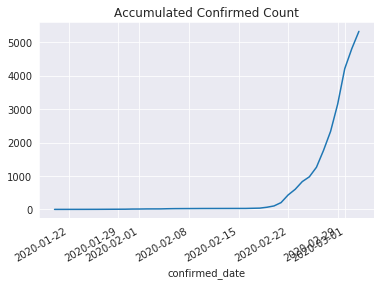

In [65]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

In [66]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )

The percentage of recovery is 0.6569069069069069
The percentage of deceased is 0.37537537537537535
The percentage of isolated is 98.96771771771772


In [67]:
import plotly.express as px

states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

released = df_patient[df_patient.state == 'released']
released.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,...,2020-02-06,NaT,released,36.0,30-39,17 days,NaT,17 days,17.0,released_female
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,...,2020-02-05,NaT,released,56.0,50-59,12 days,NaT,12 days,12.0,released_male
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,...,2020-02-12,NaT,released,54.0,50-59,17 days,NaT,17 days,17.0,released_male
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,...,2020-02-09,NaT,released,56.0,50-59,13 days,NaT,13 days,13.0,released_male
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,...,2020-03-02,NaT,released,33.0,30-39,32 days,NaT,32 days,32.0,released_male


In [68]:
#Patient Isolated
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
24,25,female,1946.0,Korea,capital area,NaN,contact with patient,2.0,27.0,12.0,...,NaT,NaT,isolated,74.0,70-79,NaT,NaT,NaT,NaN,isolated_female
25,26,male,1968.0,Korea,capital area,NaN,contact with patient,1.0,27.0,0.0,...,NaT,NaT,isolated,52.0,50-59,NaT,NaT,NaT,NaN,isolated_male
26,27,female,1982.0,China,capital area,NaN,visit to China,1.0,NaN,40.0,...,NaT,NaT,isolated,38.0,30-39,NaT,NaT,NaT,NaN,isolated_female
28,29,male,1938.0,Korea,capital area,NaN,contact with patient,4.0,83.0,117.0,...,NaT,NaT,isolated,82.0,80-89,NaT,NaT,NaT,NaN,isolated_male
29,30,female,1952.0,Korea,capital area,NaN,contact with patient,5.0,29.0,27.0,...,NaT,NaT,isolated,68.0,60-69,NaT,NaT,NaT,NaN,isolated_female


In [69]:
#Patient Died
dead = df_patient[df_patient.state == 'deceased']
dead.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,...,released_date,deceased_date,state,age,age_range,time_to_release_since_confirmed,time_to_death_since_confirmed,duration_since_confirmed,duration_days,state_by_gender
37,38,female,1963.0,Korea,Daegu,NaN,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,57.0,50-59,NaT,5 days,5 days,5.0,deceased_female
53,54,male,1963.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,57.0,50-59,NaT,4 days,4 days,4.0,deceased_male
54,55,male,1961.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-23,deceased,59.0,50-59,NaT,4 days,4 days,4.0,deceased_male
102,103,male,1957.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-19,deceased,63.0,60-69,NaT,-1 days,-1 days,-1.0,deceased_male
106,107,male,1953.0,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,NaN,NaN,NaN,NaN,...,NaT,2020-02-24,deceased,67.0,60-69,NaT,3 days,3 days,3.0,deceased_male


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



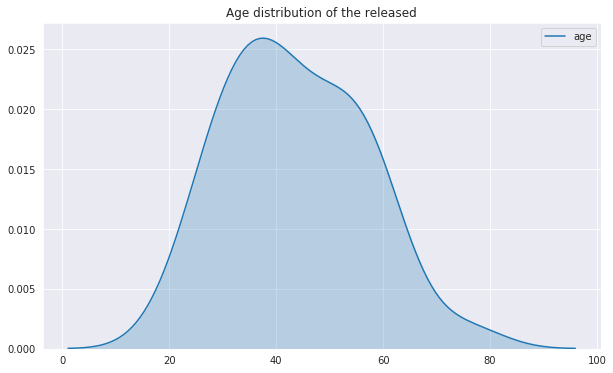

In [70]:
#Age Distribution of released
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in greater

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in less



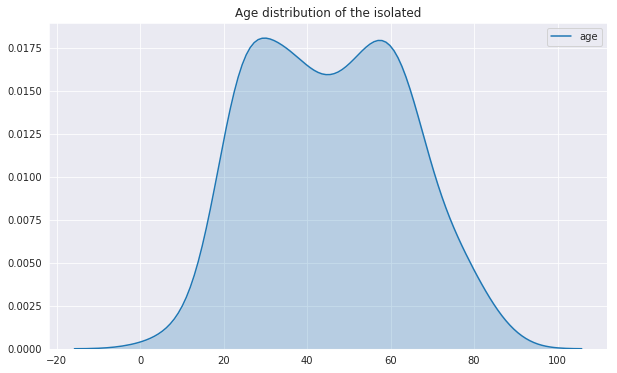

In [71]:
#Age Distribution of isolated
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

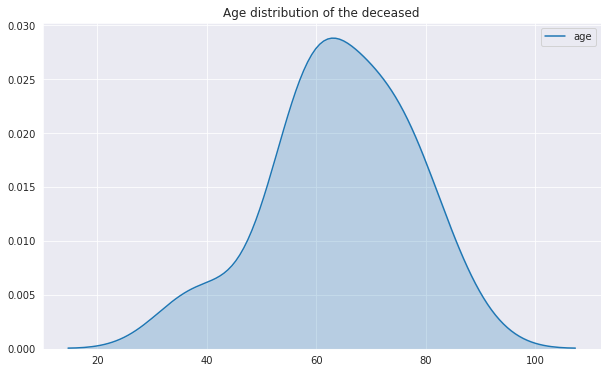

In [72]:
#Age distribution of Dead
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [73]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

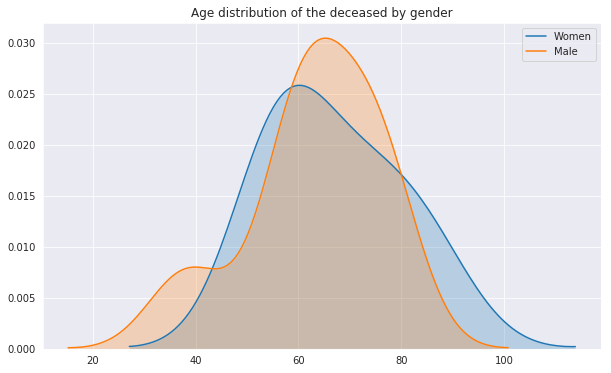

In [74]:
#Age distribution by gender (dead)
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)

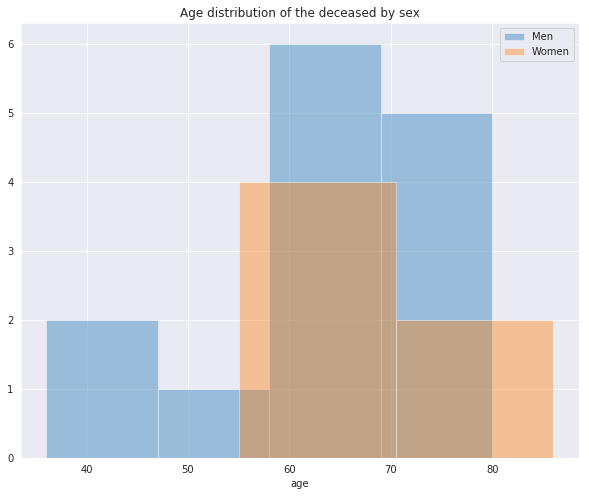

In [75]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()

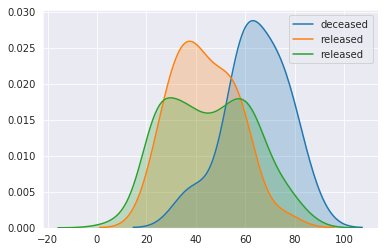

In [76]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='released', shade=True)

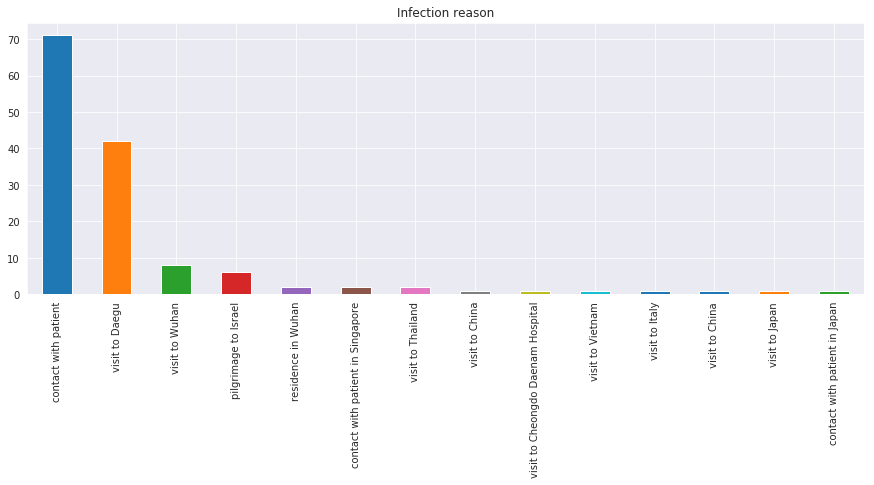

In [77]:
#Reasons foe infection

plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar();

In [78]:
df_route.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


In [79]:
df_route.isna().sum()

id           0
date         0
province     0
city         0
visit        0
latitude     0
longitude    0
dtype: int64

In [80]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

,id,latitude,longitude
0,1,37.460459,126.440680
1,1,37.478832,126.668558
2,2,37.562143,126.801884
3,2,37.567454,127.005627
4,3,37.460459,126.440680
5,3,37.524978,127.027718
6,3,37.503359,127.049177
7,3,37.524669,127.015911
8,3,37.529200,127.032597
9,3,37.674192,126.776955


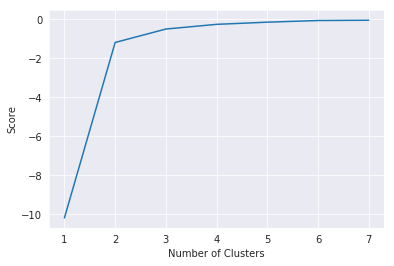

In [81]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [82]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

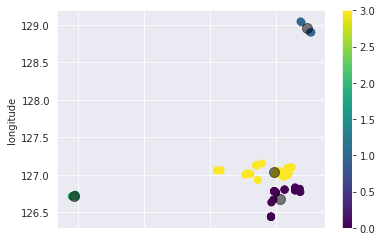

In [83]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

In [84]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

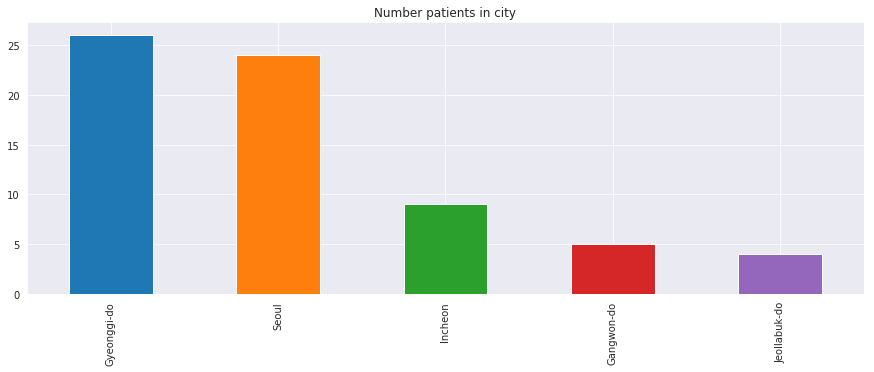

In [85]:
plt.figure(figsize=(15,5))
plt.title('Number patients in city')
df_route.province.value_counts().plot.bar();